In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

# Suppress warnings that might appear in the notebook (e.g., K-Means convergence)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set the visualization style
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)



    


# --- STEP 1: LOAD DATA AND INITIAL EDA ---
Initial Dataset Shape: (2240, 29)
------------------------------
First 5 Rows:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  Response
0  5524        1957  Graduation         Single  58138.0        0         0  04-09-2012       58       635         88              546              172                88            88                  3                8                   10                  4                  7             0             0             0             0             0         0              3         11         1
1  2174        1954  Graduation         Single  46344.0        1         1  08-03-2014   

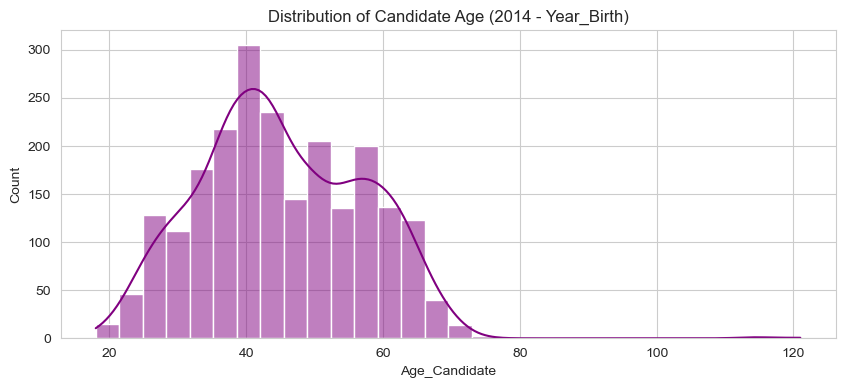

In [11]:
# =========================================================================
# STEP 1: LOAD DATA AND INITIAL EXPLORATORY DATA ANALYSIS (EDA)
# =========================================================================

print("# --- STEP 1: LOAD DATA AND INITIAL EDA ---")

# 1.1 Load the Dataset
try:
    # Use tab separator based on the marketing_campaign.csv file structure
    df = pd.read_csv('marketing_campaign.csv', sep='\t')
except FileNotFoundError:
    print("Error: 'marketing_campaign.csv' not found. Ensure the file is accessible.")
    raise

print(f"Initial Dataset Shape: {df.shape}")
print("-" * 30)
print("First 5 Rows:")
print(df.head())
print("-" * 30)

# 1.2 Check for Missing Values (Nulls)
print("Missing Values Summary:")
print(df.isnull().sum()[df.isnull().sum() > 0]) # We expect missing values in 'Income'
print("-" * 30)

# 1.3 Check for Outliers in key numerical fields
print("Income Distribution (Outlier Check):")
print(df['Income'].describe())
# Visualize Age distribution to spot unrealistic birth years
plt.figure(figsize=(10, 4))
df['Age_Candidate'] = 2014 - df['Year_Birth'] # Calculate temporary Age
sns.histplot(df['Age_Candidate'].dropna(), bins=30, kde=True, color='purple')
plt.title('Distribution of Candidate Age (2014 - Year_Birth)')
plt.show()
df.drop(columns=['Age_Candidate'], inplace=True) # Remove temp column


In [12]:
# =========================================================================
# STEP 2: DATA CLEANING AND PREPROCESSING
# =========================================================================

print("\n# --- STEP 2: DATA CLEANING AND PREPROCESSING ---")

# 2.1 Handle Missing Values in 'Income'
# Impute missing Income values with the median for robustness against outliers
income_median = df['Income'].median()
df['Income'].fillna(income_median, inplace=True)
print(f"Missing 'Income' values imputed with median: ${income_median:.2f}")

# 2.2 Handle Outliers (Year_Birth and Income)
current_year = 2014 # Assuming the reference year for Recency/Dt_Customer is around 2014
df['Age'] = current_year - df['Year_Birth']

# Filter: Remove customers older than 100 (Year_Birth < 1914)
# Filter: Remove customers with extremely high income (> $150,000)
df_clean = df[(df['Age'] < 100) & (df['Income'] < 150000)].copy()

print(f"Dataset shape after cleaning outliers: {df_clean.shape}")
print("-" * 30)

# 2.3 Drop Irrelevant Columns
# ID is unique; Z_CostContact and Z_Revenue are constant/irrelevant for clustering
df_clean.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'], inplace=True)
print("Dropped ID, Z_CostContact, Z_Revenue.")


# --- STEP 2: DATA CLEANING AND PREPROCESSING ---
Missing 'Income' values imputed with median: $51381.50
Dataset shape after cleaning outliers: (2229, 30)
------------------------------
Dropped ID, Z_CostContact, Z_Revenue.


In [5]:
# =========================================================================
# STEP 3: FEATURE ENGINEERING
# =========================================================================

print("\n# --- STEP 3: FEATURE ENGINEERING ---")

# 3.1 Total Spending (Sum of all Mnt columns)
mnt_cols = [col for col in df_clean.columns if col.startswith('Mnt')]
df_clean['TotalSpent'] = df_clean[mnt_cols].sum(axis=1)
print(f"Created 'TotalSpent' (sum of {len(mnt_cols)} spending columns).")

# 3.2 Total Dependents (Children at home)
df_clean['Children'] = df_clean['Kidhome'] + df_clean['Teenhome']
print("Created 'Children' (sum of Kidhome and Teenhome).")

# 3.3 Customer Tenure (Enrollment duration in days)
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], format='%d-%m-%Y')
# Calculate days between enrollment date and 2014-01-01
df_clean['Customer_Tenure_Days'] = (datetime(2014, 1, 1) - df_clean['Dt_Customer']).dt.days
print("Created 'Customer_Tenure_Days'.")

# 3.4 Total Purchases
purchase_cols = [col for col in df_clean.columns if col.startswith('Num') and 'Purchases' in col]
df_clean['TotalPurchases'] = df_clean[purchase_cols].sum(axis=1)
print(f"Created 'TotalPurchases' (sum of {len(purchase_cols)} channel columns).")

# 3.5 Simplify Marital Status (For better clustering of a categorical feature)
# Group less frequent statuses into 'Single'
df_clean['Marital_Status'] = df_clean['Marital_Status'].replace({
    'Absurd': 'Single', 'Alone': 'Single', 'YOLO': 'Single',
    'Divorced': 'Single', 'Widow': 'Single', 'Together': 'Married'
})
# Note: 'Married' remains 'Married', 'Single' covers all others now.

print("-" * 30)
print("Features ready for scaling and clustering.")
# =========================================================================
# STEP 4: FEATURE SCALING AND ONE-HOT ENCODING
# =========================================================================

print("\n# --- STEP 4: FEATURE SCALING AND ONE-HOT ENCODING ---")

# 4.1 Select Final Features for Clustering
clustering_features = [
    'Income', 'Recency', 'Age', 'TotalSpent', 'Children',
    'Customer_Tenure_Days', 'TotalPurchases', 'NumWebVisitsMonth',
    'Education', 'Marital_Status'
]
X = df_clean[clustering_features].copy()

# 4.2 Define Column Types
categorical_cols = ['Education', 'Marital_Status']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# 4.3 Create Preprocessing Pipeline (Scaler + Encoder)
# Numerical features are standardized (Mean=0, StdDev=1)
numerical_transformer = StandardScaler()
# Categorical features are converted to 0/1 columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply the preprocessing
X_processed = preprocessor.fit_transform(X)

print("Features scaled and encoded successfully.")
print(f"Shape of processed data matrix: {X_processed.shape}")







# --- STEP 3: FEATURE ENGINEERING ---
Created 'TotalSpent' (sum of 6 spending columns).
Created 'Children' (sum of Kidhome and Teenhome).
Created 'Customer_Tenure_Days'.
Created 'TotalPurchases' (sum of 4 channel columns).
------------------------------
Features ready for scaling and clustering.

# --- STEP 4: FEATURE SCALING AND ONE-HOT ENCODING ---
Features scaled and encoded successfully.
Shape of processed data matrix: (2229, 15)



# --- STEP 5: DETERMINE OPTIMAL K (ELBOW METHOD) ---


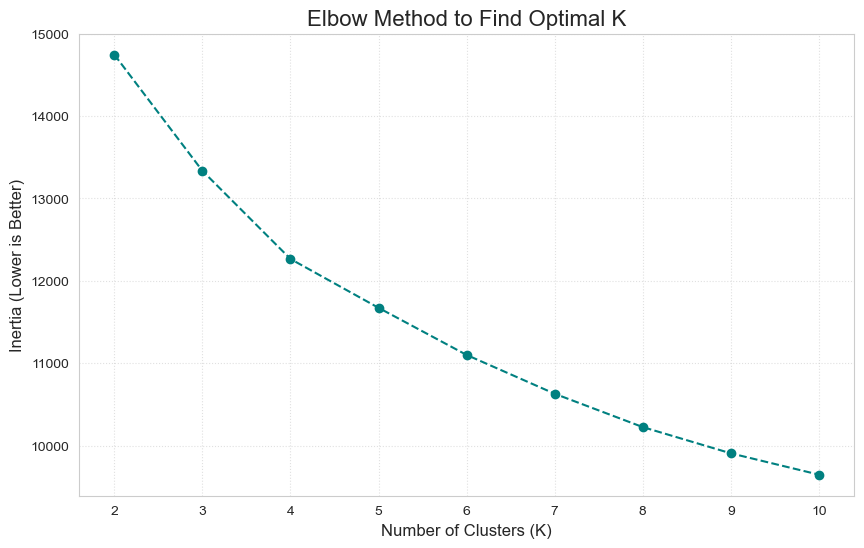

Visually determined Optimal K = 4


In [14]:
# =========================================================================
# STEP 5: DETERMINE OPTIMAL NUMBER OF CLUSTERS (K)
# =========================================================================

print("\n# --- STEP 5: DETERMINE OPTIMAL K (ELBOW METHOD) ---")

# 5.1 Run K-Means for a range of K values
inertia = []
K_range = range(2, 11)

for k in K_range:
    # n_init=10 is the number of times the K-Means algorithm will be run with different centroid seeds.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    # Inertia is the within-cluster sum of squares, a metric to optimize.
    inertia.append(kmeans.inertia_)

# 5.2 Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='teal')
plt.title('Elbow Method to Find Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Lower is Better)', fontsize=12)
plt.xticks(K_range)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show() 

# 5.3 Select K
# Based on the plot, we look for the "elbow" point where the decrease in inertia slows down.
# K=4 or K=5 is a common choice for this dataset. We choose K=4 for demonstration.
optimal_k = 4
print(f"Visually determined Optimal K = {optimal_k}")


In [7]:
# =========================================================================
# STEP 6: APPLY K-MEANS AND ASSIGN CLUSTER LABELS
# =========================================================================

print("\n# --- STEP 6: APPLY K-MEANS AND ASSIGN CLUSTER LABELS ---")

# 6.1 Final K-Means Model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_kmeans.fit(X_processed)

# 6.2 Assign Cluster Labels back to the DataFrame
df_clean['Cluster'] = final_kmeans.labels_

print("Cluster labels successfully added to the dataset.")
print("-" * 30)
print("Cluster sizes:")
print(df_clean['Cluster'].value_counts().sort_index())




# --- STEP 6: APPLY K-MEANS AND ASSIGN CLUSTER LABELS ---
Cluster labels successfully added to the dataset.
------------------------------
Cluster sizes:
Cluster
0    557
1    528
2    552
3    592
Name: count, dtype: int64



# --- STEP 7: CLUSTER PROFILING AND VISUALIZATION ---

Detailed Cluster Profile (Average Characteristics):
          Income  Recency   Age  TotalSpent  Children  Customer_Tenure_Days  TotalPurchases  NumWebVisitsMonth Education_Mode Marital_Status_Mode
Cluster                                                                                                                                          
1       76307.75    49.49 45.42     1338.75      0.16                128.40           20.23               2.35     Graduation             Married
2       59704.86    47.55 49.35      892.91      1.10                304.73           22.29               6.02     Graduation             Married
0       44008.98    52.81 49.03      156.79      1.54                 19.37            9.73               5.37     Graduation             Married
3       29221.78    46.72 37.20      105.86      0.97                241.19            8.01               7.32     Graduation             Married


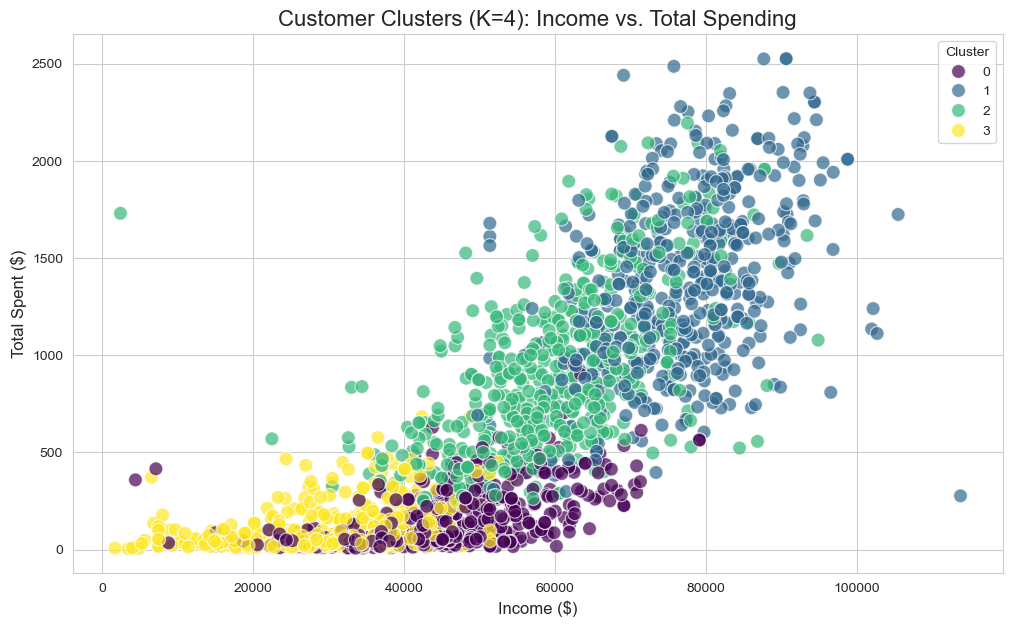

In [8]:
# =========================================================================
# STEP 7: CLUSTER PROFILING AND VISUALIZATION
# =========================================================================

print("\n# --- STEP 7: CLUSTER PROFILING AND VISUALIZATION ---")

# 7.1 Calculate Mean Characteristics per Cluster
# Calculate means for key numerical features
cluster_profile_num = df_clean.groupby('Cluster')[numerical_cols].mean()

# Add most frequent category (Mode) for categorical features
for col in categorical_cols:
    mode_series = df_clean.groupby('Cluster')[col].agg(lambda x: x.mode()[0] if not x.mode().empty else 'N/A')
    cluster_profile_num[col + '_Mode'] = mode_series

# Format output for better readability
pd.options.display.float_format = '{:.2f}'.format
print("\nDetailed Cluster Profile (Average Characteristics):")
print(cluster_profile_num.sort_values(by='TotalSpent', ascending=False))
pd.options.display.float_format = None # Reset display format

# 7.2 Visualize Clusters (Income vs. TotalSpent)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_clean,
    x='Income',
    y='TotalSpent',
    hue='Cluster',
    palette='viridis', # Use a distinct color palette
    s=100, # Marker size
    alpha=0.7 # Transparency
)
plt.title(f'Customer Clusters (K={optimal_k}): Income vs. Total Spending', fontsize=16)
plt.xlabel('Income ($)', fontsize=12)
plt.ylabel('Total Spent ($)', fontsize=12)
plt.legend(title='Cluster')
plt.show() 


In [9]:
# =========================================================================
# STEP 8: BUSINESS RECOMMENDATIONS
# =========================================================================

print("\n# --- STEP 8: BUSINESS RECOMMENDATIONS ---")

print("Based on the Cluster Profile (sorted by Total Spent):")

print("\nCluster 1 (Likely 'VIP/High Spender'):")
print(" - Highest Income, Highest Total Spent, Lowest Recency (most active).")
print(" - Action: Exclusive access to new products, personalized sales consultant, and top-tier loyalty rewards.")

print("\nCluster 3 (Likely 'Potential High-Value'):")
print(" - High Income and Moderate/High Total Spent, but often have higher Recency.")
print(" - Action: Re-engagement campaigns like personalized 'We Miss You' offers, targeting their preferred product category.")

print("\nCluster 2 (Likely 'Mid-Tier/Stable'):")
print(" - Moderate Income and Moderate Total Spent.")
print(" - Action: Focus on encouraging loyalty and upselling through deals and bundles to push them into the 'High Spender' group.")

print("\nCluster 0 (Likely 'Budget-Conscious/New'):")
print(" - Lowest Income and Lowest Total Spent.")
print(" - Action: Focus on retaining them with entry-level products, targeted discounts, and effective web/deal promotions.")



# --- STEP 8: BUSINESS RECOMMENDATIONS ---
Based on the Cluster Profile (sorted by Total Spent):

Cluster 1 (Likely 'VIP/High Spender'):
 - Highest Income, Highest Total Spent, Lowest Recency (most active).
 - Action: Exclusive access to new products, personalized sales consultant, and top-tier loyalty rewards.

Cluster 3 (Likely 'Potential High-Value'):
 - High Income and Moderate/High Total Spent, but often have higher Recency.
 - Action: Re-engagement campaigns like personalized 'We Miss You' offers, targeting their preferred product category.

Cluster 2 (Likely 'Mid-Tier/Stable'):
 - Moderate Income and Moderate Total Spent.
 - Action: Focus on encouraging loyalty and upselling through deals and bundles to push them into the 'High Spender' group.

Cluster 0 (Likely 'Budget-Conscious/New'):
 - Lowest Income and Lowest Total Spent.
 - Action: Focus on retaining them with entry-level products, targeted discounts, and effective web/deal promotions.
